1. Data processing :
two files to be processes : temperature file and population file

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
from importlib import reload
import functions as f
from tqdm import tqdm
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

In [31]:
#pop_day_europe = rio.open(r'data_population_day\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
#pop_night_europe = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')

land_cover = rio.open(r"MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif")

elevation1 = rio.open(r'elevation\30N000E_20101117_gmted_mea300.tif')
elevation2 = rio.open(r'elevation\30N030W_20101117_gmted_mea300.tif')
elevation3 = rio.open(r'elevation\50N000E_20101117_gmted_mea300.tif')
elevation4 = rio.open(r'elevation\50N030W_20101117_gmted_mea300.tif')

NDVI = xr.open_dataset(r'NDVI\c_gls_NDVI_201406110000_GLOBE_PROBAV_V2.2.1.nc')

vienna_tas = xr.open_dataset(r'data_cities\vienna_data\tas_Vienna_UrbClim_2011_08_v1.0.nc')

elev_list = [elevation1,elevation2,elevation3,elevation4]
folder = 'data_cities'

In [32]:
elevation = rio.open(r'elevation\elevation_merged.tif') 
cities = ['Amsterdam', 'Madrid', 'Stockholm', 'Lyon', 'Vienna']

In [122]:
reload(f)
#city_df = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities)
city_df_interp = pd.read_csv('data_cities/city_df.csv')
#city_df.to_csv('data_cities\city_df.csv')

In [123]:
#city_df_interp = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities, interpolation=True) #interpolation parameter chooses the method of upsampling
#city_df_interp.to_csv('data_cities\city_df_interp.csv')

In [124]:
latitudes = {'Amsterdam' : 52.377956, 'Madrid' : 40.416775, 'Stockholm' : 59.329323, 'Lyon' : 45.764043, 'Vienna' : 48.208174}
#add a column with the latitude of the city
city_df_interp['latitude'] = city_df_interp['city'].map(latitudes)
#remplace negative pop values with 0
city_df_interp['pop'] = city_df_interp['pop'].apply(lambda x: 0 if x < 0 else x)
city_df_interp.head()

,Unnamed: 0,temp,pop,wind,hum,deltaT,hour,month,elevation,city,land cover type,NDVI,isrural,latitude
0,0,274.48145,0.000000,2.208353,92.426930,-0.513397,18,1,0.0,Amsterdam,3.0,0.936,1.0,52.377956
1,1,273.67807,1.753243,4.078188,86.734920,0.607880,20,1,4.0,Amsterdam,15.0,0.920,NaN,52.377956
2,2,278.45407,11029.792192,3.854456,85.954350,0.746094,13,1,7.0,Amsterdam,1.0,0.448,NaN,52.377956
3,3,279.59946,3182.414418,3.749156,88.955230,-0.185394,13,1,0.0,Amsterdam,22.0,0.672,NaN,52.377956
4,4,276.39307,0.000000,4.549990,95.903534,-0.240265,16,1,0.0,Amsterdam,3.0,0.936,1.0,52.377956


In [125]:
city_df_interp.fillna(0, inplace=True)
city_df_interp.describe().loc[:,'pop']

count    2.214463e+06
mean     1.302441e+03
std      2.964728e+03
min      0.000000e+00
25%      2.766911e+00
50%      1.135271e+02
75%      1.091769e+03
max      3.432265e+04
Name: pop, dtype: float64

array([<Axes: title={'center': 'NDVI'}>], dtype=object)

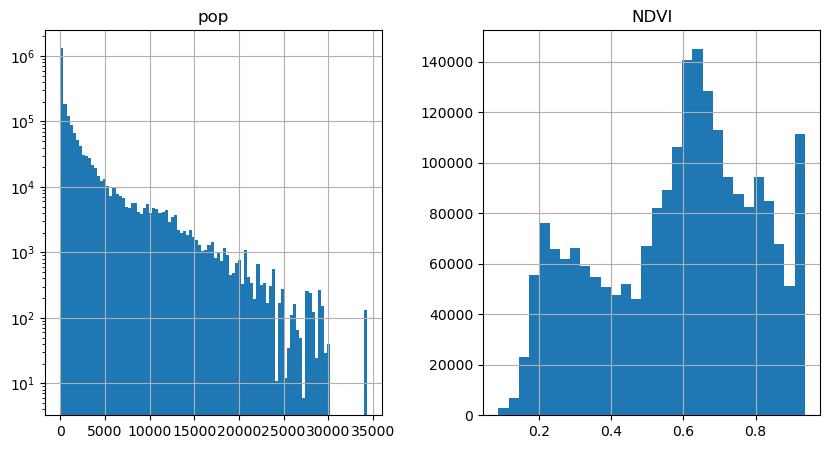

In [126]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
city_df_interp.hist(column='pop', bins=100, log=True, ax=axs[0])
city_df_interp.hist(column='NDVI', bins=30, ax=axs[1])


Lets do some exploratory data analysis on the data first

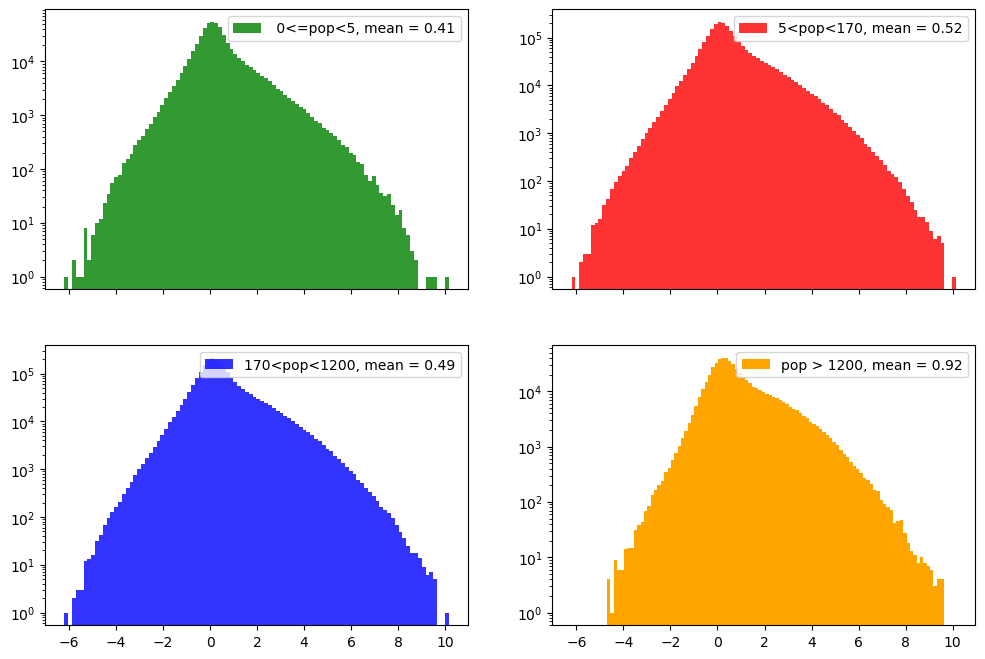

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['pop']>=2) & city_df_interp['pop']<115]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'5<pop<170, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>=2) & city_df_interp["pop"]<115]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["pop"]<2)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=pop<5, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>0) & (city_df_interp["pop"]<2)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['pop']>115) & city_df_interp['pop']<1083]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'170<pop<1200, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>115) & (city_df_interp["pop"]<1083)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['pop']>1083]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'pop > 1200, mean = {np.mean(city_df_interp[city_df_interp["pop"]>1083]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


In [128]:
city_df_interp['NDVI'].describe()

count    2.214463e+06
mean     5.834231e-01
std      2.133033e-01
min      8.800001e-02
25%      4.160000e-01
50%      6.160001e-01
75%      7.480001e-01
max      9.360000e-01
Name: NDVI, dtype: float64

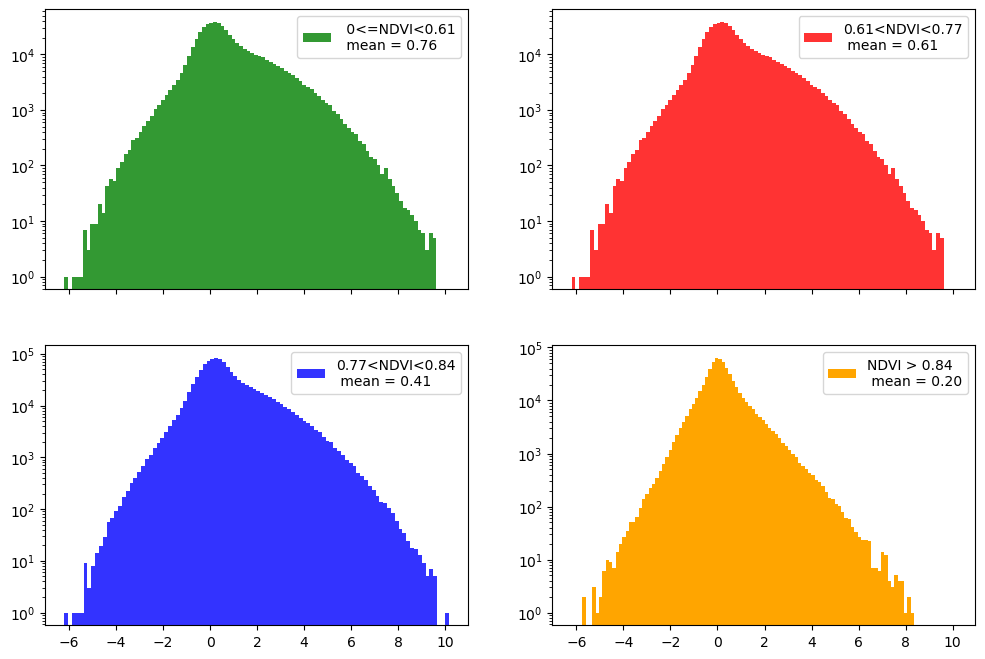

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['NDVI']>=0.41) & city_df_interp['NDVI']<0.61]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'0.61<NDVI<0.77\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>=0.41) & city_df_interp["pop"]<0.61]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["NDVI"]<0.41)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=NDVI<0.61\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0) & (city_df_interp["NDVI"]<0.41)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['NDVI']>0.61) & city_df_interp['NDVI']<0.74]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'0.77<NDVI<0.84\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0.61) & (city_df_interp["NDVI"]<0.74)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['NDVI']>=0.74]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'NDVI > 0.84\n mean = {np.mean(city_df_interp[city_df_interp["NDVI"]>=0.74]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


Text(0.5, 1.0, 'Avg DeltaT vs NDVI')

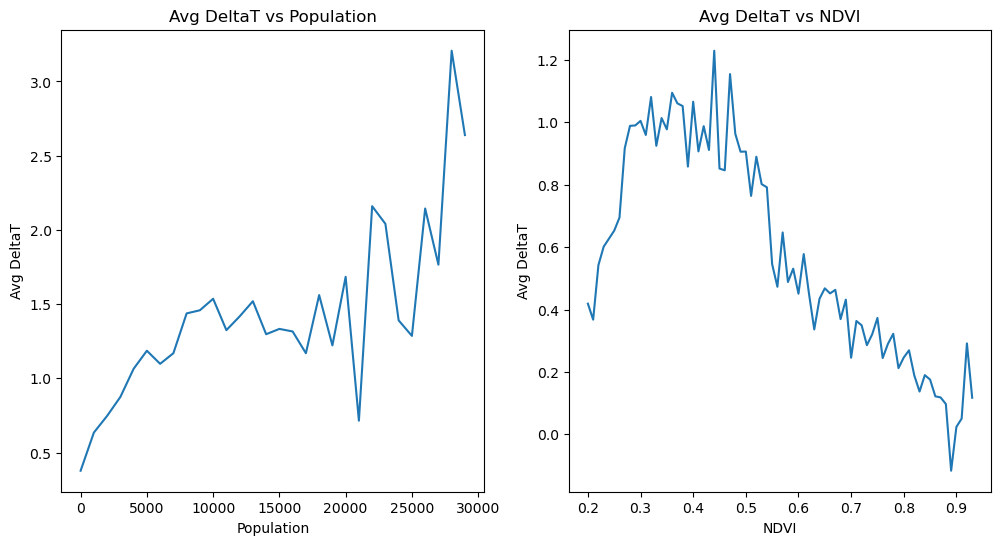

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#create a list of tuples with population intervals
pop_intervals = [(i,i+1000) for i in range(0, 30000, 1000)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['pop']>i) & (city_df_interp['pop']<j)]['deltaT']) for i,j in pop_intervals]
#plot the avg deltaT for each population interval
axs[0].plot([i for i,j in pop_intervals], deltaT_list)
axs[0].set_xlabel('Population')
axs[0].set_ylabel('Avg DeltaT')
axs[0].set_title('Avg DeltaT vs Population')

#create a list of tuples with NDVI intervals (between 0 and 1)
NDVI_intervals = [(i/100, (i+1)/100) for i in range(20, 100)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['NDVI']>i) & (city_df_interp['NDVI']<j)]['deltaT']) for i,j in NDVI_intervals]
#plot the avg deltaT for each NDVIulation interval
axs[1].plot([i for i,j in NDVI_intervals], deltaT_list)
axs[1].set_xlabel('NDVI')
axs[1].set_ylabel('Avg DeltaT')
axs[1].set_title('Avg DeltaT vs NDVI')


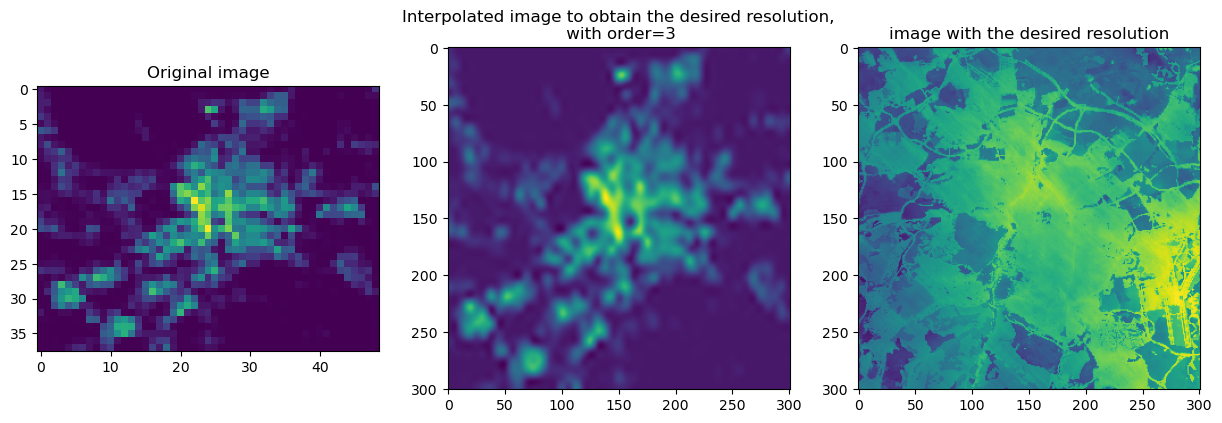

In [131]:
#method of interpolation

import numpy as np
import scipy.ndimage

temp_madrid = xr.open_dataset(r'data_cities\madrid_data\tas_Madrid_UrbClim_2011_09_v1.0.nc')
pop_day_m = rio.open(r'data_population_day\ENACT_POP_D092011_EU28_R2020A_4326_30ss_V1_0.tif')

pop_day_m = f.crop_image(pop_day_m, temp_madrid)
x = pop_day_m


#subplot of the original image and interpolated image
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x)
axs[0].set_title('Original image')
axs[1].imshow(scipy.ndimage.zoom(x, (301/x.shape[0], 301/x.shape[1]), order=3))
axs[1].set_title('Interpolated image to obtain the desired resolution,\n with order=3')
axs[2].imshow(temp_madrid['tas'][0,:,:])
axs[2].set_title('image with the desired resolution')
plt.show()


In [132]:
#store the quartiles of the deltaT
q1 = city_df_interp['deltaT'].quantile(0.25)
q2 = city_df_interp['deltaT'].quantile(0.5)
q3 = city_df_interp['deltaT'].quantile(0.75)


In [133]:
#create a column with population category : 0 for pop<100, 2 for 100<pop<1000, 2 for 1000<pop<100000, 3 for pop>100000 and a deltaT category : 0 for deltaT<q1, 1 for q1<deltaT<q2, 2 for q2<deltaT<q3, 3 for deltaT>q3
city_df_interp['pop_cat'] = city_df_interp['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
city_df_interp['deltaT_cat'] = city_df_interp['deltaT'].apply(lambda x : 0 if x<=q1 else (1 if x<=q2 else (2 if x<=q3 else 3)))

In [134]:
city_df_interp.fillna(0, inplace=True) #replace NaN values by 0 (only happens for the isrural column)


In [145]:
#Linear regression using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

city_df_test = city_df_interp[city_df_interp['city'] != 'Lyon'].sample(300000) #we choose a sample of 300000 datapoints to train the model, excluding Lyon

X = city_df_test[city_df_test['isrural'] == 0][['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']]
y = city_df_test[city_df_test['isrural'] == 0]['deltaT']

#standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']] = scaler.fit_transform(X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']])

#sample the data so that we have equal number of samples per category of deltaT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['deltaT_cat'])
#remove deltaT_cat from the data
X_train.drop(columns=['deltaT_cat'], inplace=True)
X_test.drop(columns=['deltaT_cat'], inplace=True)




'''#sample the data to have equal data per category of population
X_sampled = pd.DataFrame(columns = X.columns)
for i in range(4):
    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])

indexes = X_sampled.index
y_sampled = y_train.loc[indexes]'''


"#sample the data to have equal data per category of population\nX_sampled = pd.DataFrame(columns = X.columns)\nfor i in range(4):\n    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])\n\nindexes = X_sampled.index\ny_sampled = y_train.loc[indexes]"

# Multi-layer Perceptron regressor

MLP are a category of machine learning algorithm consisting in at least 3 layers of fully interconnected neurons. Learning occurs by changing the connection weights base on the error between the predicted and the actual output. The backpropagation algorithm is used to calculate the error and update the weights. The major disadvantage of MLP is that it is very computationally expensive to train. Here is a schema of an MLP regressor from Skiba (2020)
<p align="center">
  <img src="Example-of-multilayer-perceptron-MLP-network-for-regression-analysis-here-n-13-and.png" />
</p>


In [48]:
#Implement MLP regressor
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(max_iter=500, hidden_layer_sizes=(100),
                    activation='relu', verbose=True, solver='adam',
                    alpha=0.0001, random_state=42, tol = 10e-5, learning_rate_init=0.001,
                    learning_rate='adaptive', warm_start=True, epsilon=0.001, early_stopping=True,
                    validation_fraction=0.1, n_iter_no_change=10,
                    )

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))




Iteration 1, loss = 0.35991972
Validation score: 0.743451
Iteration 2, loss = 0.15072085
Validation score: 0.747281
Iteration 3, loss = 0.13904017
Validation score: 0.783555
Iteration 4, loss = 0.12715046
Validation score: 0.786847
Iteration 5, loss = 0.12165745
Validation score: 0.795176
Iteration 6, loss = 0.11972483
Validation score: 0.793160
Iteration 7, loss = 0.11918385
Validation score: 0.769273
Iteration 8, loss = 0.11761435
Validation score: 0.804055
Iteration 9, loss = 0.11685207
Validation score: 0.797105
Iteration 10, loss = 0.11641972
Validation score: 0.808496
Iteration 11, loss = 0.11528628
Validation score: 0.805558
Iteration 12, loss = 0.11497249
Validation score: 0.809942
Iteration 13, loss = 0.11376495
Validation score: 0.812799
Iteration 14, loss = 0.11315839
Validation score: 0.816491
Iteration 15, loss = 0.11252220
Validation score: 0.787480
Iteration 16, loss = 0.11209679
Validation score: 0.816389
Iteration 17, loss = 0.11060949
Validation score: 0.797039
Iterat

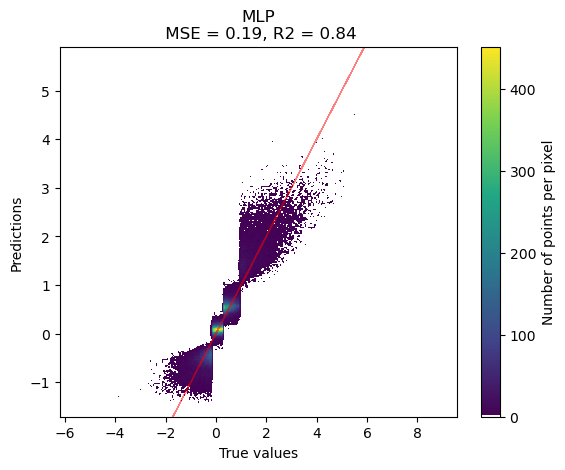

In [49]:
#plot the predictions vs the true values
fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'MLP\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='red', linewidth=.5, alpha = 0.5)
fig.show()

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
MSE:  0.3453690935835009
R2:  0.7489045494070236


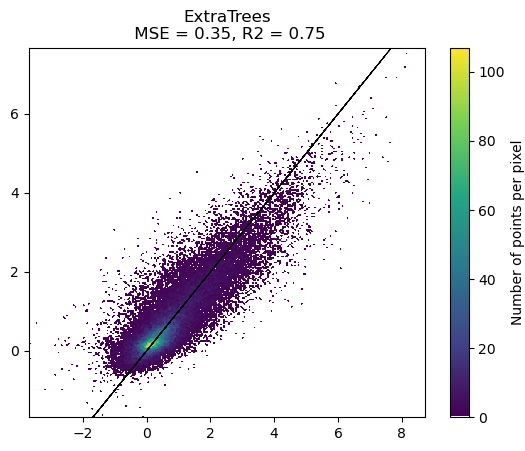

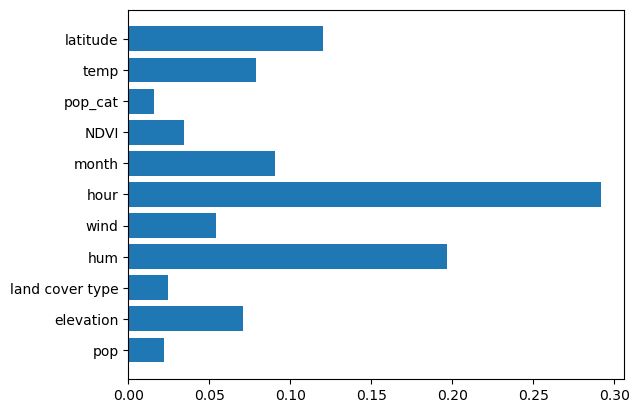

In [178]:
#extra trees
from sklearn.ensemble import ExtraTreesRegressor

cv = ExtraTreesRegressor(random_state=42, n_jobs=1, n_estimators=10, max_depth=20, min_samples_split=2, max_features=10, verbose=2)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

#print variance and bias
fig = plt.figure()
f.using_mpl_scatter_density(fig,y_test, y_pred)
plt.plot(y_test, y_test, color='black', linewidth=.5, linestyle='dashed')
plt.title(f'ExtraTrees\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.show()


#plot feature importance
plt.figure()
plt.barh(X_train.columns, cv.feature_importances_)
plt.show()



# Gradient Boosting regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The sklearn histGradientBoostingRegressor is based on the LightGBM method that uses an histogram based method to bin the features, therefore using less memory and being faster than the classical gradient boosting method. Here is a schema of the gradient boosting algorithm.
<p align="center">
  <img src="Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png" />
</p>


Binning 0.012 GB of training data: 

0.274 s
Binning 0.001 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.56224, val loss: 0.56260, in 0.024s
[2/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.54283, val loss: 0.54329, in 0.029s
[3/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.52621, val loss: 0.52662, in 0.021s
[4/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.51225, val loss: 0.51291, in 0.023s
[5/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.50000, val loss: 0.50078, in 0.034s
[6/1000] 1 tree, 31 leaves, max depth = 7, train loss: 0.48971, val loss: 0.49059, in 0.035s
[7/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.48058, val loss: 0.48180, in 0.028s
[8/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.47271, val loss: 0.47402, in 0.025s
[9/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.46565, val loss: 0.46732, in 0.035s
[10/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.45962, val loss: 0.

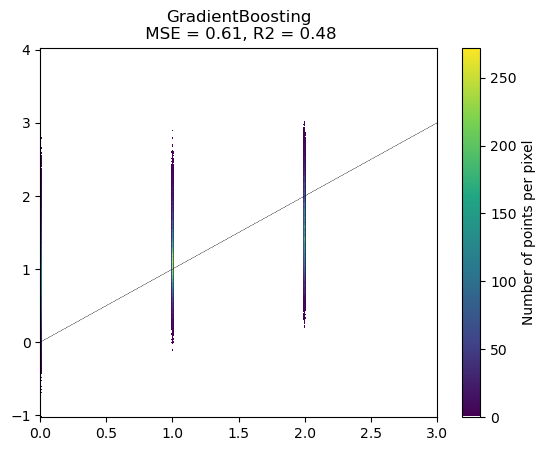

In [30]:
#Gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = HistGradientBoostingRegressor(random_state=42, max_depth=15, learning_rate=0.1, min_samples_leaf=2, max_iter=1000, verbose=1, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=10e-5)    


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.title(f'GradientBoosting\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='black', linestyle='dashed', linewidth=.2)

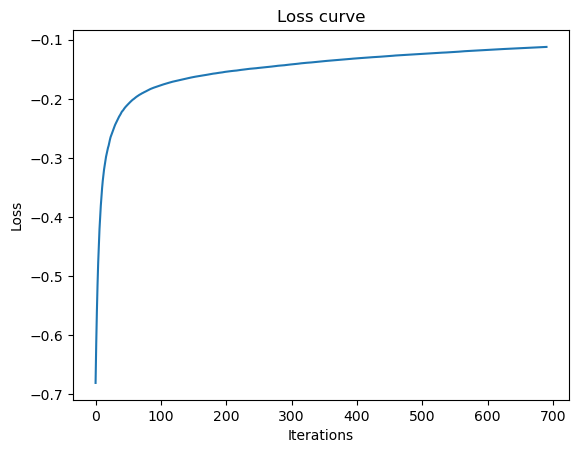

In [147]:
#plot loss curve
plt.figure()
plt.plot(model.train_score_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()


In [149]:
model_final = model
print(model_final.predict(X_test.iloc[140:150]))
print(y_test.iloc[140:150].values)

[ 1.54175333  1.5080187   0.29427247 -0.12811075  1.11017965  0.36220472
  0.24094485  1.49472048  0.1226967  -0.37524264]
[ 1.9172974   1.6564331   0.4593506   0.04779053  1.5427856   0.28533936
  0.04275513  0.48709106 -0.12457275 -0.44122314]


In [150]:
print(cv.predict(X_test.iloc[140:150]))
print(y_test.iloc[140:150].values)

[ 1.4353085   1.52337167  0.38211024 -0.00689558  1.1514853   0.1960819
  0.49673461  1.68205724  0.17026193 -0.26773088]
[ 1.9172974   1.6564331   0.4593506   0.04779053  1.5427856   0.28533936
  0.04275513  0.48709106 -0.12457275 -0.44122314]


In [55]:
#export the model
'''import pickle
filename = 'finalized_model.sav'
pickle.dump(model_final, open(filename, 'wb'))'''


Number of nan values in deltaT:  28411
Number of nan values in deltaT_predicted:  28411


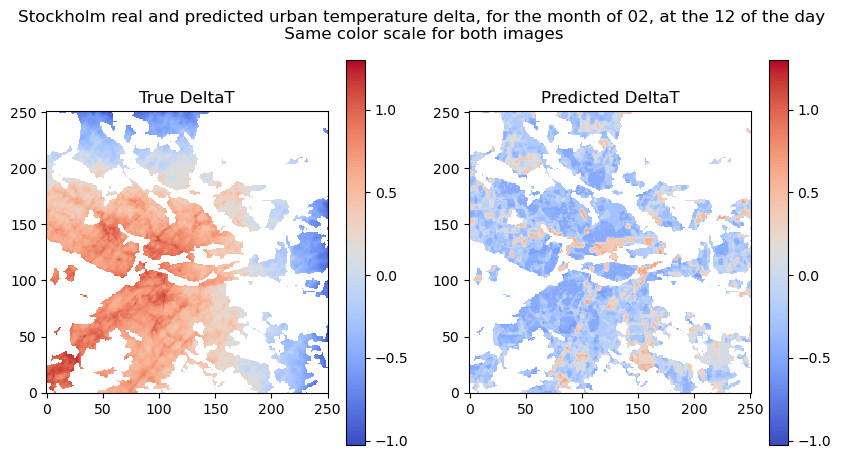

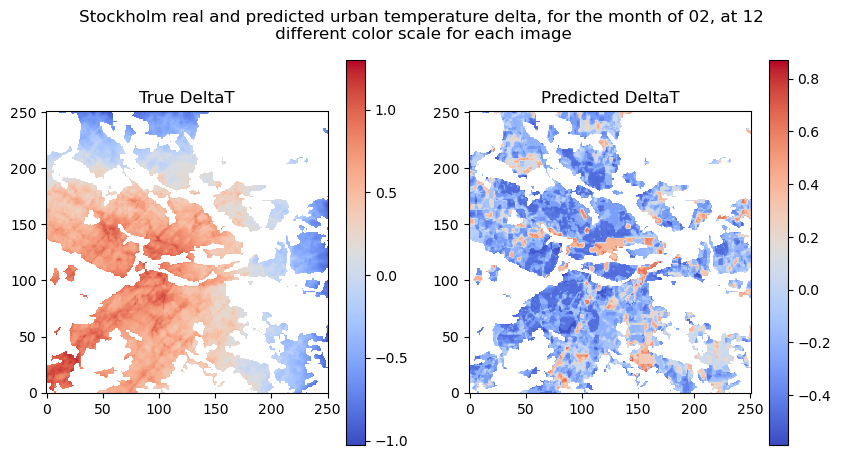

In [192]:
#visualize the prediction for a city, month and given hour (in the training set)
deltat, predictedDT = f.visualization_prediction('Stockholm', 24*12+12, cv, 2, [q1, q2, q3], cmap = 'coolwarm')

Number of nan values in deltaT:  50317
Number of nan values in deltaT_predicted:  50317


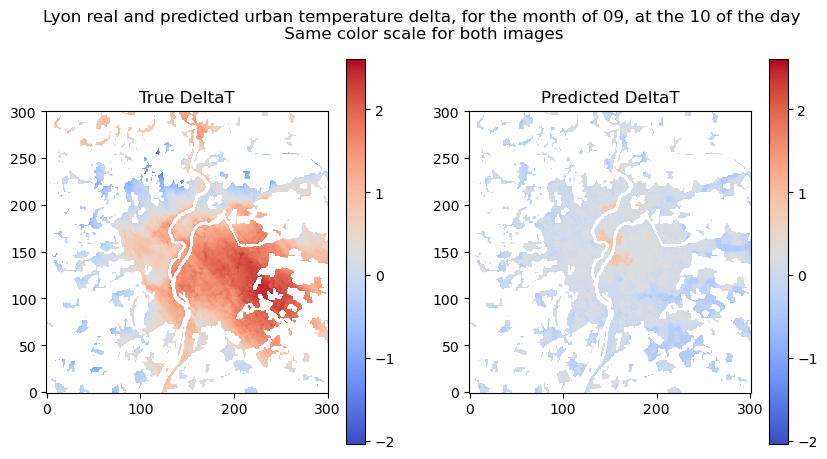

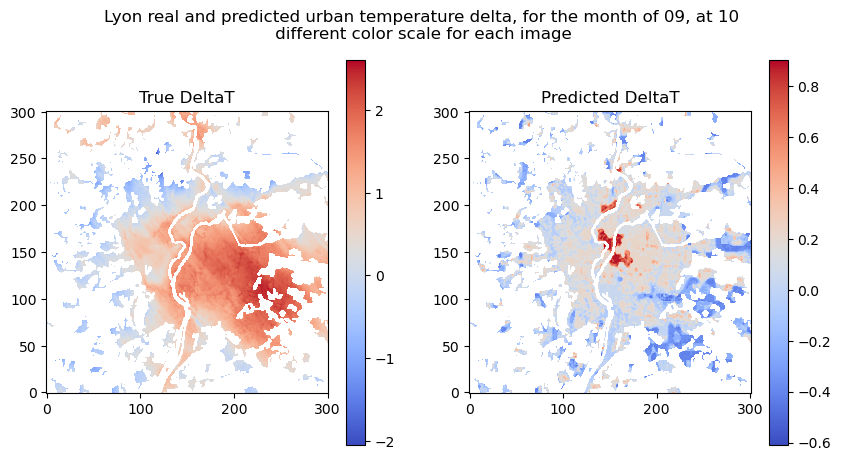

In [187]:
#Visualize the prediction for a city, month and given hour (not in the train set)
deltat, predictedDT = f.visualization_prediction('Lyon', 24*12+10, cv, 9, [q1, q2, q3], cmap = 'coolwarm')

## Analysis

The model is not good at predicting precisely contours of the UHIs but more to give an average magnitude over all urban pixels. This is due to the disparity in the distribution of the magnitude of UHIs.

By adding add a small 'helping' categorical variable that indicates the model what is the magnitude category of the UHI, the results obtained are much more precise. A simple division of the temperature in 4 categories (based on the quartiles of the the distribution of the train set) permits to obtain a R^2 of.9 and a MSE of .2, and the visualization is much more interesting

In [12]:
model_final = pickle.load(open('finalized_model.sav', 'rb'))
city_df_interp = pd.read_csv('data_cities/city_df.csv')

latitudes = {'Amsterdam' : 52.377956, 'Madrid' : 40.416775, 'Stockholm' : 59.329323, 'Lyon' : 45.764043, 'Vienna' : 48.208174}
#add a column with the latitude of the city
city_df_interp['latitude'] = city_df_interp['city'].map(latitudes)

q1 = city_df_interp['deltaT'].quantile(0.25)
q2 = city_df_interp['deltaT'].quantile(0.5)
q3 = city_df_interp['deltaT'].quantile(0.75)


Number of nan values in deltaT:  51922
Number of nan values in deltaT_predicted:  51922


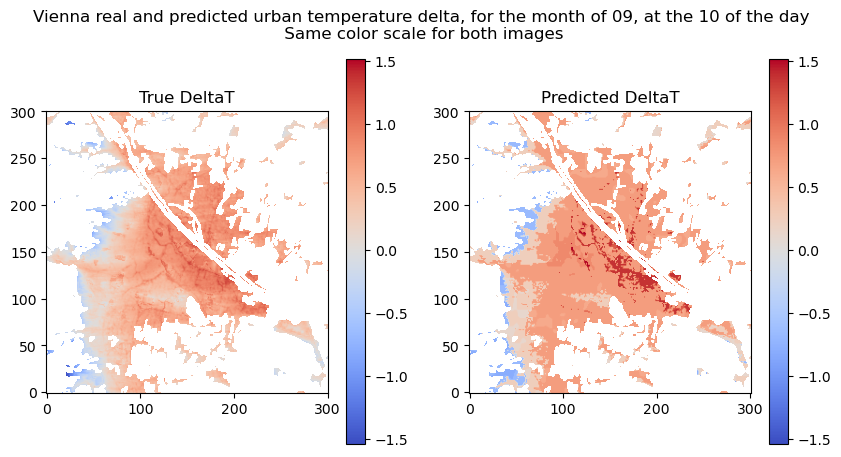

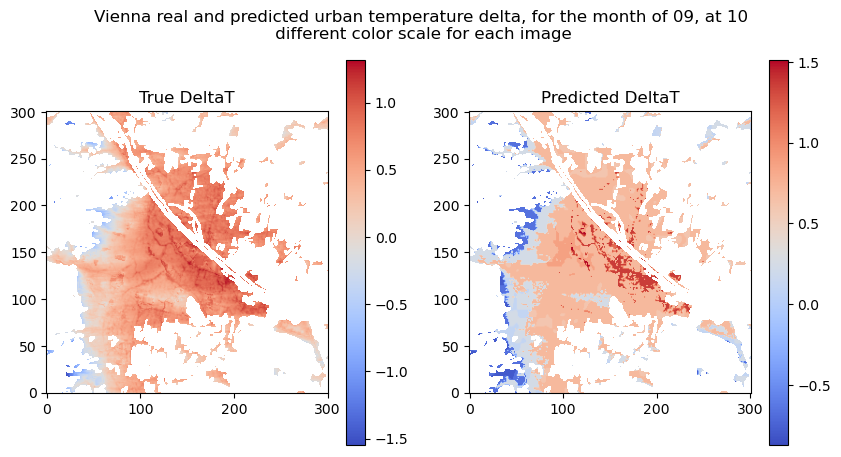

In [31]:
#1. for a city in the training set (need to use a model that was trained with the deltaT cat in the first place)
deltat, predictedDT, _ = f.visualization_prediction('Vienna', 24*12+10, model_final, 9, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

Number of nan values in deltaT:  50317
Number of nan values in deltaT_predicted:  50317


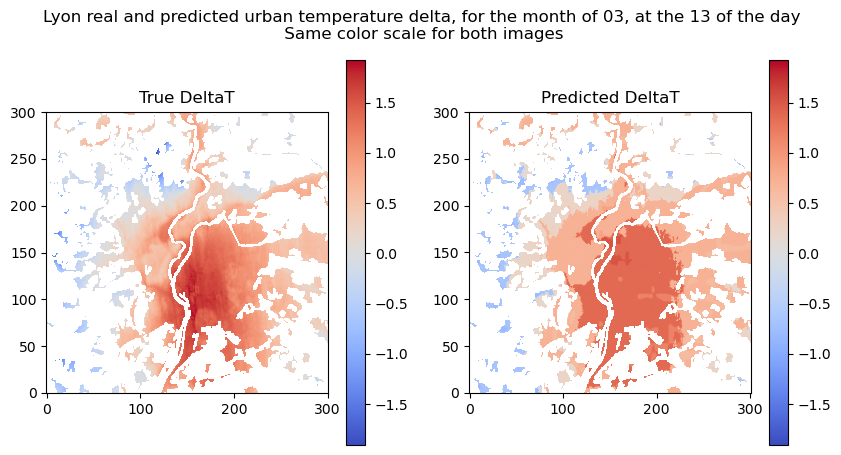

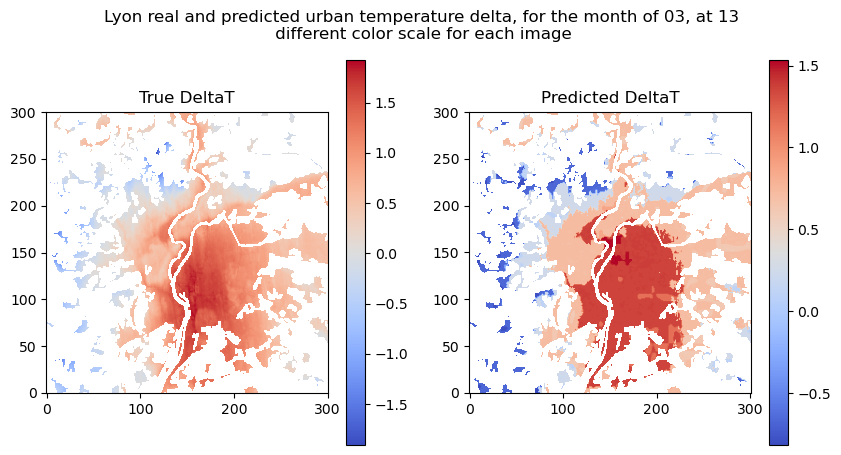

In [10]:
#2. for a city not in the training set
deltat, predictedDT, _ = f.visualization_prediction('Lyon', 24*12+13, model_final, 3, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

we can check if we can predict the deltaT catergory with a somehow high accuracy

deltaT_cat
0    49422
1    55489
2    51990
3    43099
Name: latitude, dtype: int64


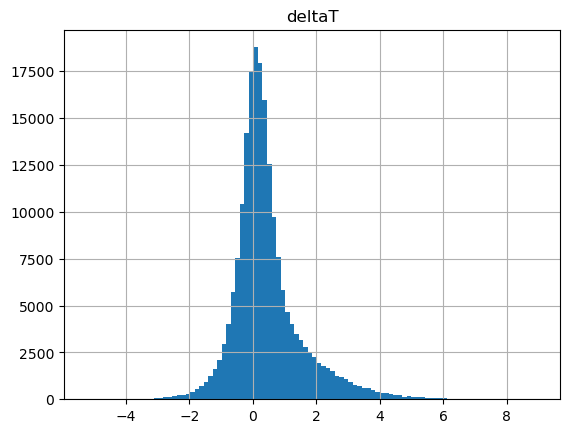

In [15]:
from sklearn.model_selection import train_test_split
#we can try to predict the category of deltaT for a city tho
test_df = city_df_interp[city_df_interp['city'] != 'Lyon'].sample(200000)

test_df.hist(column='deltaT', bins=100)

test_df['deltaT_cat'] = test_df['deltaT'].apply(lambda x : 0 if x<=q1 else (1 if x<=q2 else (2 if x<=q3 else 3)))
print(test_df.groupby('deltaT_cat')['latitude'].count())
X = test_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'temp', 'latitude']]
y = test_df['deltaT_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)



In [16]:
#import a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
clf_rf = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=42, n_jobs=1, verbose=4, min_samples_split=2, max_features=10)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
print('Accuracy: ', clf_rf.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
Accuracy:  0.53805
F1 score:  0.5345187563867095
Precision:  0.5333517580640742
Recall:  0.53805


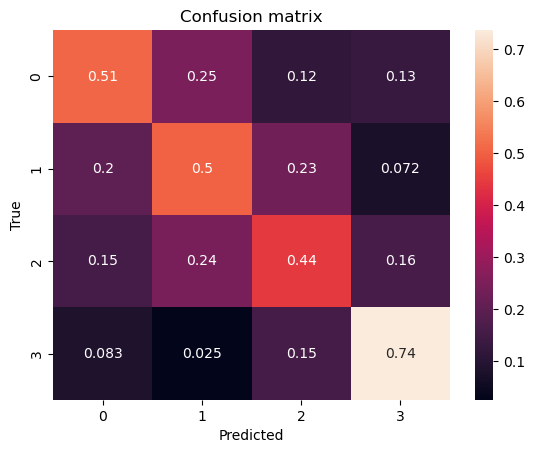

In [17]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

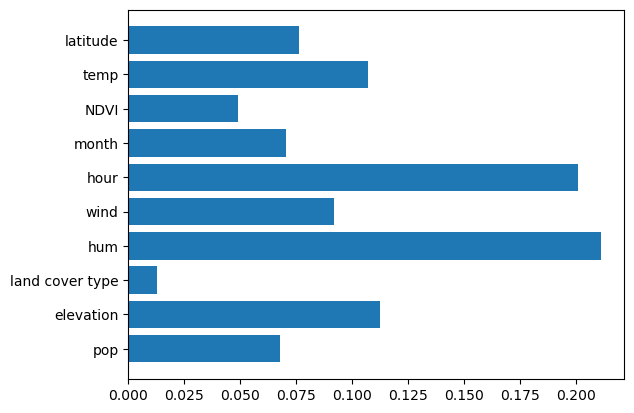

In [18]:
#print feature importance
plt.figure()
plt.barh(X_train.columns, clf.feature_importances_)
plt.show()


Accuracy:  0.439325
F1 score:  0.4385219790300538
Precision:  0.4450101415038134
Recall:  0.439325


Text(0.5, 1.0, 'Confusion matrix')

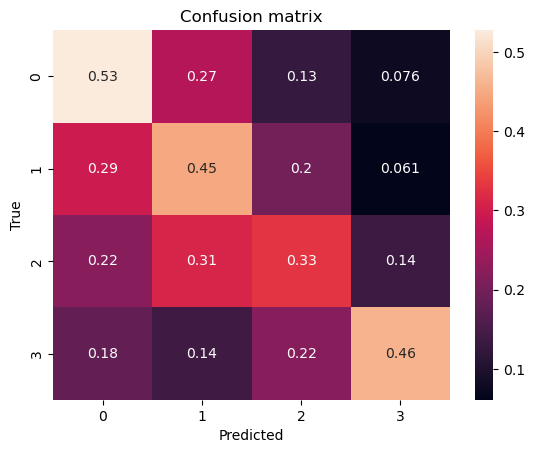

In [24]:
#KNN classifier
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=6, n_jobs=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', clf.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')

Accuracy:  0.51805
F1 score:  0.5136239081106513
Precision:  0.5129717109118411
Recall:  0.51805


Text(0.5, 1.0, 'Confusion matrix')

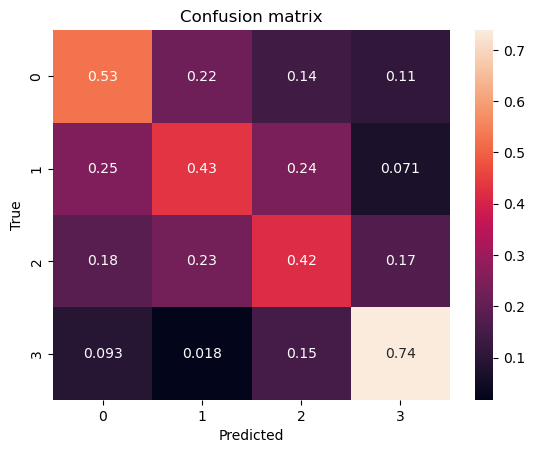

In [25]:
#ada boost with weak classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=3), random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', clf.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')

Iteration 1, loss = 3.78288438
Validation score: 0.298875
Iteration 2, loss = 2.81140297
Validation score: 0.351187
Iteration 3, loss = 2.53366068
Validation score: 0.363187
Iteration 4, loss = 2.49333261
Validation score: 0.331125
Iteration 5, loss = 2.37618475
Validation score: 0.372063
Iteration 6, loss = 2.09414381
Validation score: 0.343250
Iteration 7, loss = 1.90075649
Validation score: 0.414625
Iteration 8, loss = 1.80606379
Validation score: 0.344938
Iteration 9, loss = 1.77561198
Validation score: 0.402438
Iteration 10, loss = 1.64815217
Validation score: 0.401187
Iteration 11, loss = 1.64058150
Validation score: 0.414375
Iteration 12, loss = 1.51480759
Validation score: 0.377000
Iteration 13, loss = 1.44988697
Validation score: 0.399375
Iteration 14, loss = 1.38556734
Validation score: 0.425063
Iteration 15, loss = 1.34918444
Validation score: 0.404687
Iteration 16, loss = 1.31475891
Validation score: 0.444125
Iteration 17, loss = 1.24239833
Validation score: 0.450062
Iterat

Text(0.5, 23.52222222222222, 'Predicted')

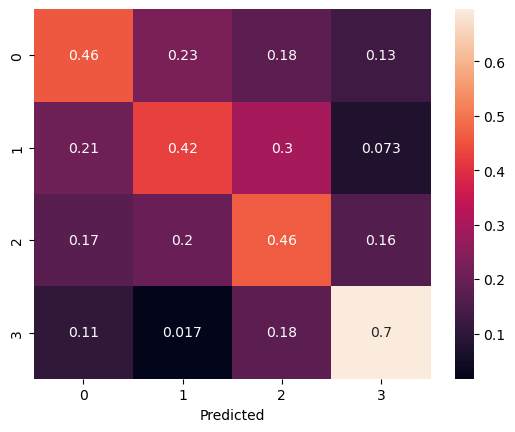

In [26]:
#MLP classifier
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, verbose=True, learning_rate='adaptive', early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=10e-5, activation='relu', solver='adam', random_state=42, alpha=0.0001, learning_rate_init=0.001, warm_start=True, epsilon=0.001)
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)
print('Accuracy: ', clf_mlp.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')

Number of nan values in deltaT:  28411
Number of nan values in deltaT_predicted:  28411


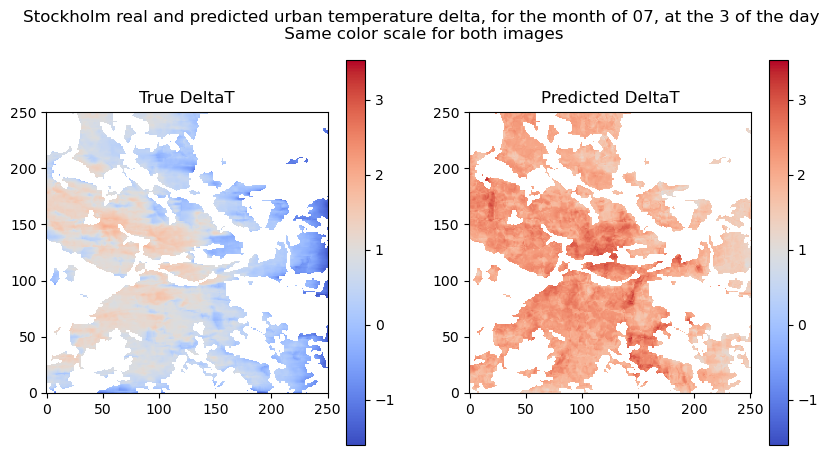

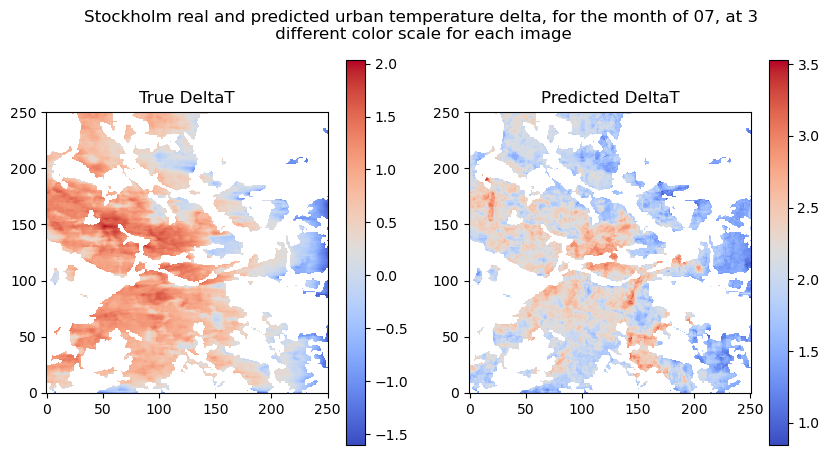

In [122]:
reload(f)
deltaT, predictedDT, madrid_df = f.visualization_prediction('Stockholm', 24*7+3, model, 7, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=False)

In [123]:
madrid_df['deltaT_cat_predicted'] = clf.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'temp', 'latitude']])

In [124]:
madrid_df.groupby('deltaT_cat')['deltaT_cat'].value_counts()

deltaT_cat
0    20013
1    10586
2    20207
3    12195
Name: count, dtype: int64

In [125]:
madrid_df.groupby('deltaT_cat_predicted')['deltaT_cat_predicted'].value_counts()

deltaT_cat_predicted
0       20
1     5991
2    36596
3    20394
Name: count, dtype: int64

Text(0.5, 1.0, 'Predicted values of deltaT category')

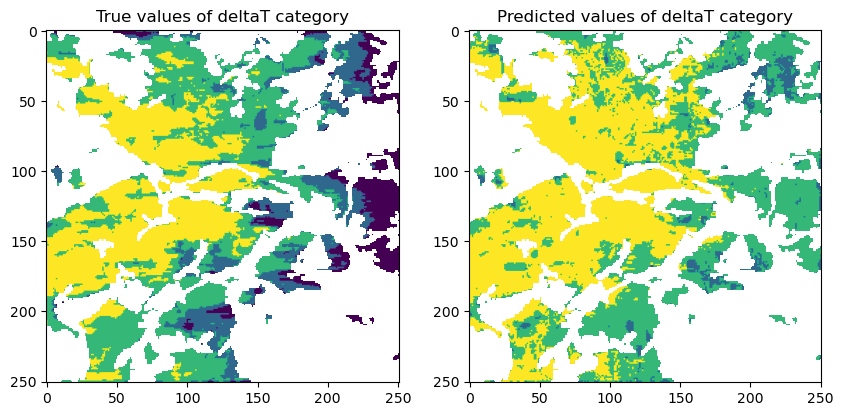

In [127]:
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df[madrid_df['isrural'] == 1] = np.nan

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(madrid_df['deltaT_cat'].values.reshape(251,251))
ax[0].set_title('True values of deltaT category')
ax[1].imshow(madrid_df['deltaT_cat_predicted'].values.reshape(251,251))
ax[1].set_title('Predicted values of deltaT category')

In [128]:
final_model = pickle.load(open('finalized_model.sav', 'rb'))

In [129]:
#visualize the deltaT predicted using the deltaT_cat_predicted
madrid_df['deltaT_cat'] = madrid_df['deltaT_cat_predicted']
madrid_df['pop_cat'] = madrid_df['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df['deltaT_predicted'] = final_model.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']])



Text(0.5, 1.0, 'Predicted values')

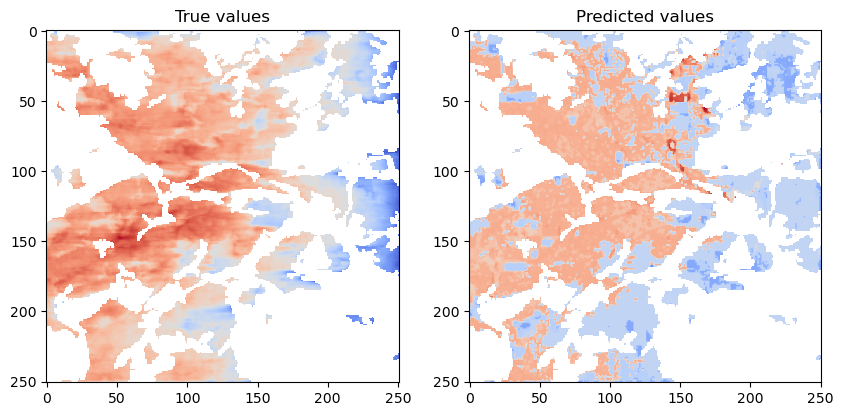

In [131]:
#plot the prediction and the true values with the same color scale
fig, ax = plt.subplots(1,2, figsize=(10,5))

deltaT_predicted = madrid_df['deltaT_predicted']
deltaT_predicted[madrid_df['iswater'] != 1] = np.nan
deltaT_predicted[madrid_df['isrural'] != 0] = np.nan
deltaT_predicted = deltaT_predicted.values.reshape(251,251)
ax[0].imshow(madrid_df['deltaT'].values.reshape(251,251), cmap='coolwarm')
ax[0].set_title('True values')
ax[1].imshow(deltaT_predicted, cmap='coolwarm')
ax[1].set_title('Predicted values')

